# softmax回归的从零开始实现
:label:`sec_softmax_scratch`

(**就像我们从零开始实现线性回归一样，**)
我们认为softmax回归也是重要的基础，因此(**应该知道实现softmax回归的细节**)。
本节我们将使用刚刚在 :numref:`sec_fashion_mnist`中引入的Fashion-MNIST数据集，
并设置数据迭代器的批量大小为256。


In [3]:
import torch
from IPython import display

# from d2l import torch as d2l

In [6]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 初始化模型参数

和之前线性回归的例子一样，这里的每个样本都将用固定长度的向量表示。
原始数据集中的每个样本都是$28 \times 28$的图像。
本节[**将展平每个图像，把它们看作长度为784的向量。**]
在后面的章节中，我们将讨论能够利用图像空间结构的特征，
但现在我们暂时只把每个像素位置看作一个特征。

回想一下，在softmax回归中，我们的输出与类别一样多。
(**因为我们的数据集有10个类别，所以网络输出维度为10**)。
因此，权重将构成一个$784 \times 10$的矩阵，
偏置将构成一个$1 \times 10$的行向量。
与线性回归一样，我们将使用正态分布初始化我们的权重`W`，偏置初始化为0。


In [7]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## 定义softmax操作

在实现softmax回归模型之前，我们简要回顾一下`sum`运算符如何沿着张量中的特定维度工作。
如 :numref:`subseq_lin-alg-reduction`和
 :numref:`subseq_lin-alg-non-reduction`所述，
 [**给定一个矩阵`X`，我们可以对所有元素求和**]（默认情况下）。
 也可以只求同一个轴上的元素，即同一列（轴0）或同一行（轴1）。
 如果`X`是一个形状为`(2, 3)`的张量，我们对列进行求和，
 则结果将是一个具有形状`(3,)`的向量。
 当调用`sum`运算符时，我们可以指定保持在原始张量的轴数，而不折叠求和的维度。
 这将产生一个具有形状`(1, 3)`的二维张量。


In [8]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

回想一下，[**实现softmax**]由三个步骤组成：

1. 对每个项求幂（使用`exp`）；
1. 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
1. 将每一行除以其规范化常数，确保结果的和为1。

在查看代码之前，我们回顾一下这个表达式：

(**
$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$
**)

分母或规范化常数，有时也称为*配分函数*（其对数称为对数-配分函数）。
该名称来自[统计物理学](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))中一个模拟粒子群分布的方程。


In [9]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

正如上述代码，对于任何随机输入，[**我们将每个元素变成一个非负数。
此外，依据概率原理，每行总和为1**]。


In [10]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0552, 0.0294, 0.0999, 0.0299, 0.7857],
         [0.1152, 0.1926, 0.2763, 0.2516, 0.1643]]),
 tensor([1., 1.]))

注意，虽然这在数学上看起来是正确的，但我们在代码实现中有点草率。
矩阵中的非常大或非常小的元素可能造成数值上溢或下溢，但我们没有采取措施来防止这点。

## 定义模型

定义softmax操作后，我们可以[**实现softmax回归模型**]。
下面的代码定义了输入如何通过网络映射到输出。
注意，将数据传递到模型之前，我们使用`reshape`函数将每张原始图像展平为向量。


In [11]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

## 定义损失函数

接下来，我们实现 :numref:`sec_softmax`中引入的交叉熵损失函数。
这可能是深度学习中最常见的损失函数，因为目前分类问题的数量远远超过回归问题的数量。

回顾一下，交叉熵采用真实标签的预测概率的负对数似然。
这里我们不使用Python的for循环迭代预测（这往往是低效的），
而是通过一个运算符选择所有元素。
下面，我们[**创建一个数据样本`y_hat`，其中包含2个样本在3个类别的预测概率，
以及它们对应的标签`y`。**]
有了`y`，我们知道在第一个样本中，第一类是正确的预测；
而在第二个样本中，第三类是正确的预测。
然后(**使用`y`作为`y_hat`中概率的索引**)，
我们选择第一个样本中第一个类的概率和第二个样本中第三个类的概率。


In [34]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

现在我们只需一行代码就可以[**实现交叉熵损失函数**]。


In [35]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

## 分类精度

给定预测概率分布`y_hat`，当我们必须输出硬预测（hard prediction）时，
我们通常选择预测概率最高的类。
许多应用都要求我们做出选择。如Gmail必须将电子邮件分类为“Primary（主要邮件）”、
“Social（社交邮件）”“Updates（更新邮件）”或“Forums（论坛邮件）”。
Gmail做分类时可能在内部估计概率，但最终它必须在类中选择一个。

当预测与标签分类`y`一致时，即是正确的。
分类精度即正确预测数量与总预测数量之比。
虽然直接优化精度可能很困难（因为精度的计算不可导），
但精度通常是我们最关心的性能衡量标准，我们在训练分类器时几乎总会关注它。

为了计算精度，我们执行以下操作。
首先，如果`y_hat`是矩阵，那么假定第二个维度存储每个类的预测分数。
我们使用`argmax`获得每行中最大元素的索引来获得预测类别。
然后我们[**将预测类别与真实`y`元素进行比较**]。
由于等式运算符“`==`”对数据类型很敏感，
因此我们将`y_hat`的数据类型转换为与`y`的数据类型一致。
结果是一个包含0（错）和1（对）的张量。
最后，我们求和会得到正确预测的数量。


In [36]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

我们将继续使用之前定义的变量`y_hat`和`y`分别作为预测的概率分布和标签。
可以看到，第一个样本的预测类别是2（该行的最大元素为0.6，索引为2），这与实际标签0不一致。
第二个样本的预测类别是2（该行的最大元素为0.5，索引为2），这与实际标签2一致。
因此，这两个样本的分类精度率为0.5。


In [37]:
accuracy(y_hat, y) / len(y)

0.5

同样，对于任意数据迭代器`data_iter`可访问的数据集，
[**我们可以评估在任意模型`net`的精度**]。


In [38]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

这里定义一个实用程序类`Accumulator`，用于对多个变量进行累加。
在上面的`evaluate_accuracy`函数中，
我们在(**`Accumulator`实例中创建了2个变量，
分别用于存储正确预测的数量和预测的总数量**)。
当我们遍历数据集时，两者都将随着时间的推移而累加。


In [39]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

由于我们使用随机权重初始化`net`模型，
因此该模型的精度应接近于随机猜测。
例如在有10个类别情况下的精度为0.1。


In [40]:
evaluate_accuracy(net, test_iter)

0.0985

## 训练

在我们看过 :numref:`sec_linear_scratch`中的线性回归实现，
[**softmax回归的训练**]过程代码应该看起来非常眼熟。
在这里，我们重构训练过程的实现以使其可重复使用。
首先，我们定义一个函数来训练一个迭代周期。
请注意，`updater`是更新模型参数的常用函数，它接受批量大小作为参数。
它可以是`d2l.sgd`函数，也可以是框架的内置优化函数。


In [41]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

在展示训练函数的实现之前，我们[**定义一个在动画中绘制数据的实用程序类**]`Animator`，
它能够简化本书其余部分的代码。


In [43]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 替换 d2l.use_svg_display()
        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = figsize
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 替换 d2l.set_axes，使用 lambda 函数直接配置参数
        self.config_axes = lambda: self._set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴标签、范围和比例"""
        import matplotlib.pyplot as plt
        # 设置坐标轴标签
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        # 设置坐标轴范围
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        # 设置坐标轴比例
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        # 设置图例
        if legend:
            ax.legend(legend)
        # 添加网格
        ax.grid(True)

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

接下来我们实现一个[**训练函数**]，
它会在`train_iter`访问到的训练数据集上训练一个模型`net`。
该训练函数将会运行多个迭代周期（由`num_epochs`指定）。
在每个迭代周期结束时，利用`test_iter`访问到的测试数据集对模型进行评估。
我们将利用`Animator`类来可视化训练进度。


In [44]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

作为一个从零开始的实现，我们使用 :numref:`sec_linear_scratch`中定义的
[**小批量随机梯度下降来优化模型的损失函数**]，设置学习率为0.1。


In [45]:
lr = 0.1

def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

def updater(batch_size):
    return sgd([W, b], lr, batch_size)

现在，我们[**训练模型10个迭代周期**]。
请注意，迭代周期（`num_epochs`）和学习率（`lr`）都是可调节的超参数。
通过更改它们的值，我们可以提高模型的分类精度。


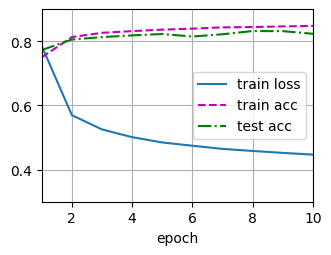

In [46]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## 预测

现在训练已经完成，我们的模型已经准备好[**对图像进行分类预测**]。
给定一系列图像，我们将比较它们的实际标签（文本输出的第一行）和模型预测（文本输出的第二行）。


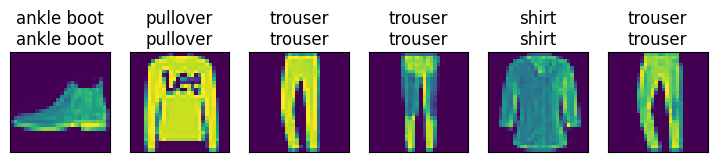

In [47]:
import matplotlib.pyplot as plt

def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## 小结

* 借助softmax回归，我们可以训练多分类的模型。
* 训练softmax回归循环模型与训练线性回归模型非常相似：先读取数据，再定义模型和损失函数，然后使用优化算法训练模型。大多数常见的深度学习模型都有类似的训练过程。

## 练习

1. 本节直接实现了基于数学定义softmax运算的`softmax`函数。这可能会导致什么问题？提示：尝试计算$\exp(50)$的大小。
1. 本节中的函数`cross_entropy`是根据交叉熵损失函数的定义实现的。它可能有什么问题？提示：考虑对数的定义域。
1. 请想一个解决方案来解决上述两个问题。
1. 返回概率最大的分类标签总是最优解吗？例如，医疗诊断场景下可以这样做吗？
1. 假设我们使用softmax回归来预测下一个单词，可选取的单词数目过多可能会带来哪些问题?


In [48]:
# 展示softmax函数中的潜在问题
def softmax_naive(X):
    """基于数学定义的朴素softmax实现"""
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

# 创建一个包含大数值的输入
large_input = torch.tensor([[1, 2, 50]])
print(f"输入: {large_input}")

# 尝试计算exp(50)
print(f"exp(50) = {torch.exp(torch.tensor(50.0))}")

# 尝试使用朴素softmax计算
try:
    result_naive = softmax_naive(large_input)
    print(f"朴素softmax结果: {result_naive}")
    print(f"结果总和: {result_naive.sum()}")
except Exception as e:
    print(f"计算出错: {e}")

# 使用数值稳定的softmax实现
def softmax_stable(X):
    """数值稳定的softmax实现"""
    # 减去每行的最大值
    X_shifted = X - X.max(dim=1, keepdim=True).values
    X_exp = torch.exp(X_shifted)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

# 使用稳定版本计算
result_stable = softmax_stable(large_input)
print(f"\n稳定softmax结果: {result_stable}")
print(f"稳定结果总和: {result_stable.sum()}")

输入: tensor([[ 1,  2, 50]])
exp(50) = 5.184705457665547e+21
朴素softmax结果: tensor([[5.2429e-22, 1.4252e-21, 1.0000e+00]])
结果总和: 1.0

稳定softmax结果: tensor([[5.2429e-22, 1.4252e-21, 1.0000e+00]])
稳定结果总和: 1.0


In [49]:
import torch
import math

# 展示对数函数在接近0时的行为
print("对数函数在接近0时的行为:")
print(f"log(0.1) = {math.log(0.1)}")
print(f"log(0.01) = {math.log(0.01)}")
print(f"log(0.001) = {math.log(0.001)}")
print(f"log(1e-10) = {math.log(1e-10)}")
print(f"log(1e-15) = {math.log(1e-15)}")

# 当前cross_entropy实现的问题演示
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

# 创建一个包含接近0概率值的示例
y_hat_problematic = torch.tensor([[1e-10, 1-1e-10], [0.7, 0.3]])  # 第一个样本的第一个类概率非常小
y = torch.tensor([0, 1])  # 真实标签

print("\n问题示例:")
print(f"预测概率: {y_hat_problematic}")
print(f"真实标签: {y}")
print(f"第一个样本第一类的概率: {y_hat_problematic[0, 0]}")

try:
    loss = cross_entropy(y_hat_problematic, y)
    print(f"交叉熵损失: {loss}")
    print(f"第一个样本的损失: {loss[0]}")  # 这会是一个非常大的数
except Exception as e:
    print(f"计算出错: {e}")

# 更极端的情况
y_hat_extreme = torch.tensor([[1e-20, 1-1e-20], [0.8, 0.2]])
print(f"\n更极端的情况 - 概率: {y_hat_extreme[0, 0]}")
try:
    loss_extreme = cross_entropy(y_hat_extreme, torch.tensor([0, 1]))
    print(f"对应的损失: {loss_extreme[0]}")
except Exception as e:
    print(f"计算出错: {e}")

对数函数在接近0时的行为:
log(0.1) = -2.3025850929940455
log(0.01) = -4.605170185988091
log(0.001) = -6.907755278982137
log(1e-10) = -23.025850929940457
log(1e-15) = -34.538776394910684

问题示例:
预测概率: tensor([[1.0000e-10, 1.0000e+00],
        [7.0000e-01, 3.0000e-01]])
真实标签: tensor([0, 1])
第一个样本第一类的概率: 1.000000013351432e-10
交叉熵损失: tensor([23.0259,  1.2040])
第一个样本的损失: 23.025850296020508

更极端的情况 - 概率: 9.999999682655225e-21
对应的损失: 46.051700592041016


[Discussions](https://discuss.d2l.ai/t/1789)
